__1.Goal: examine the homogeneous tissue competition with cross interaction by dynamics__

1. Investigate how $f_c$ change the cross-interaction coefficients

2. Ideally, these coefficients should be independent of initial fraction according to the mean field approximation. Check if initial fraction $\phi_0$ influence these coefficients.

examine the dynamics:
$$\partial _t \phi = \kappa_{eff} \Delta P_{eff}^{AB} \phi (1-\phi)$$
where $\kappa_{eff}= \frac{\kappa_A \kappa_B}{\kappa_A \phi+\kappa_B(1-\phi)}$, $P_{eff}^A(\phi) =P_H^A + \frac{ \Delta k_s^{AB}(1-\phi)}{\kappa_A}$, $ P_{eff}^B(\phi) = P_H^B + \frac{ \Delta k_s^{BA}\phi}{\kappa_B}$ and $\Delta P_{eff}^{AB} = P_{eff}^A(\phi)-P_{eff}^B(\phi)$.

__2.Set up of simulation__

The set up of following simulations are:

Type A: $G = 30, f_1^A = 5.0$     

Type B: $G = 34, f_1^B = 6.0$

cross adhesion strength $f_1^C = 5.0,5.5,6.0$

Initial fraction of type B: $\phi_{ini}= 0.1,0.3,0.5,0.7,0.9$

Initial configuration: well-mixed initially

__3.Analysis and curvefit the data__

We use a dynamical system's differential equation to curve-fit the dynamics of homogeneous competition, where $\Delta k_s^{AB}$ and $\Delta k_s^{BA}$ are the parameters to be fitted. For each set of dynamics data, we can obtain a set of fitted parameters $\Delta k_s^{AB}$ and $\Delta k_s^{BA}$.
The code below demonstrates an example of how the differential equation is used to curve-fit the dynamics of the case where $f_1^C = 6.0$ and $\phi_A(t=0) = 0.3$ and obtain the fitted parameters $\Delta k_s^{AB}, \Delta k_s^{BA}$

In [10]:
import os
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
#dksa is equivalent to Delta_k_s_AB
#dksb is equivalent to Delta_k_s_BA
a = 0.8255197434137439
b = -4.433211634010404
c = 10.564378211438262
kappa_a,kappa_b,PHA,PHB = 0.2059,0.1632,a*30+b*5+c,a*34+b*6+c#kappa are acquired by their adhesion strength

# Peff_A and Peff_B
def P_eff_A(phi, Delta_k_s_AB):
    return PHA + Delta_k_s_AB * (1 - phi) / kappa_a

def P_eff_B(phi, Delta_k_s_BA):
    return PHB + Delta_k_s_BA * phi / kappa_b

# define Delta_P_eff
def Delta_P_eff(phi, Delta_k_s_AB, Delta_k_s_BA):
    return P_eff_A(phi, Delta_k_s_AB) - P_eff_B(phi, Delta_k_s_BA)
    
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
#Goal:
#return the value of differential equation: \partial_t phi = s(\phi) \phi (1-\phi)
#Input:
#t,phi: time, fraction of cell A
#Delta_k_s_AB,Delta_k_s_BA: cross interaction coefficients \Delta k_s^{AB},\Delta k_s^{BA}
#Output:
#dphi_dt: \partial_t phi
def func_homogeneous_competition(t,phi,Delta_k_s_AB,Delta_k_s_BA):
    k_eff = kappa_a*kappa_b/(kappa_a*phi+kappa_b*(1-phi))
    PA_eff = PHA+ Delta_k_s_AB*(1-phi)/kappa_a
    PB_eff = PHB+ Delta_k_s_BA*phi/kappa_b
    r_A = k_eff*PA_eff
    r_B = k_eff*PB_eff
    selc_coeff = r_A-r_B
    dphi_dt = selc_coeff * phi * (1-phi)
    return dphi_dt

#Goal:
#Solve the differential equation \partial_t phi = s(\phi) \phi (1-\phi) and return the fraction of phi as function of \phi
#Input:
#params: parameters frac, Delta_k_s_AB and Delta_k_s_BA
#t_data: time columns from the file 'numcell.dat'
#Output:
#sol.y[0]: the fraction of phi
def model_function(params,t_data,phi0):
    Delta_k_s_AB,Delta_k_s_BA= params
    sol = solve_ivp(lambda t,phi: func_homogeneous_competition(t,phi,Delta_k_s_AB,Delta_k_s_BA),[t_data[0],t_data[-1]],[phi0],t_eval=t_data)
    return sol.y[0]
#Goal:
#return the sum of difference between the actual data and model result of \phi, this step is prepared for the next step 'minimize'
def loss_function(params,t_data,phi_data,phi0):
    phi_model = model_function(params,t_data,phi0)
    return np.sum((phi_model-phi_data)**2)

#define the equaton of pressure evolution
def eq_pressure_evolution(phi,vars,phi0):
    Delta_k_s_AB, Delta_k_s_BA = vars
    #phi = model_function(vars,t,phi0)
    pressure_Numerator = (kappa_a * phi * P_eff_A(phi, Delta_k_s_AB) + kappa_b * (1 - phi) * P_eff_B(phi, Delta_k_s_BA))
    pressure_Denominator = (kappa_a * phi + kappa_b * (1 - phi))
    return pressure_Numerator/pressure_Denominator 


#Goal:
#Read the file 'numcell.dat', curve fit it with the dynamical equation, obtain Delta_k_s_AB,Delta_k_s_BA.
#Finally plot the data and fitting function
#Input:
#file_path: the path of the file 'numcells.dat'
#ax: the figure to plot
#Output:
#frac: the initial fraction of cell A
#Delta_k_s_AB,Delta_k_s_BA: cross interaction coefficients \Delta k_s^AB, \Delta k_s^BA
def read_numcell_and_plot(folder_path, ax, color_map,frac):
    frac = float(folder_path.split('/')[-2].split('_')[-1])  # Initial fraction acquired by the file path
    fc = folder_path.split('/')[-3]
    color = color_map[frac]
    
    data = pd.read_csv(folder_path + "/numcells.dat", sep='\t')  # Read file
    t_data = (data.iloc[:, 0].values / 100)[100:]  # Normalized time by multiplying apoptosis rate
    phi_data = (data.iloc[:, 1] / (data.iloc[:, 2] + data.iloc[:, 1])).values[100:]  # Evolution of fraction of cell A
    initial_guess = [0, 0.4]
    result = minimize(loss_function, initial_guess, args=(t_data[:-300], phi_data[:-300], frac))  # Obtain cross interaction coefficients by fitting function
    Delta_k_s_AB, Delta_k_s_BA = result.x[0], result.x[1]  # Cross interaction coefficients
    ax.plot(t_data, model_function(result.x, t_data, frac), 'r-', label='Fitted curve')
    ax.plot(t_data, phi_data, label=f'Data (frac={frac})', color=color)
#     ax.plot(t_data, model_function(result.x, t_data, frac), 'r-', label=f'Fitted curve Δk_s^AB={np.round(Delta_k_s_AB, 3)} Δk_s^BA={np.round(Delta_k_s_BA, 3)}', color=color)
    
    ax.set_xlabel('time *ka')
    ax.set_ylabel(r'cell A fraction $\phi$')
    ax.set_title('fc=' + fc.split('_')[1])
    return frac, Delta_k_s_AB, Delta_k_s_BA
#Goal:
#Read the file '__curp.dat', using the formula of system pressure with given dksa and dksb
#Finally plot the data and fitting function
#Input:
#file_path: the path of the file 'numcell.dat'
#ax: the figure to plot
#Output:
#frac: the initial fraction of cell A
#Delta_k_s_AB,Delta_k_s_BA: cross interaction coefficients \Delta k_s^AB, \Delta k_s^BA    


def read_pressure_and_plot(folder_path, vars, ax, window_size=20):
    frac = float(folder_path.split('/')[-2].split('_')[-1])  # Initial fraction acquired by the file path
    fc = folder_path.split('/')[-3]

    num_data = pd.read_csv(folder_path+"/numcells.dat",sep='\t') #read file
    num_t_data = (num_data.iloc[:,0].values/100)[100:] # normalized time by multiplying apoptosis rate
    phi_data = (num_data.iloc[:,1]/(num_data.iloc[:,2]+num_data.iloc[:,1])).values[100:]#evolution of fraction of cell A

    data = pd.read_csv(folder_path+"/__curp.dat", sep='\t')  # Read file
    t_data = (data.iloc[:, 0].values / 100)[10:]  # Normalized time by multiplying apoptosis rate
    pressure_data = data.iloc[:, 1][10:]
    
    # Smooth the pressure_data
    smoothed_pressure_data = moving_average(pressure_data, window_size)
    
    # Adjust t_data to match the length of smoothed_pressure_data
    t_data_smoothed = t_data[:len(smoothed_pressure_data)]
    
    ax.plot(t_data_smoothed, smoothed_pressure_data,'blue',alpha=0.1, label='Data')
    ax.plot(num_t_data, eq_pressure_evolution(phi_data, vars, frac),'r',label='Theoretical result')
    ax.set_xlabel('time *ka')
    ax.set_ylabel(r'System pressure $P$')
    ax.set_title('Evoltuion of system pressure P')
    ax.legend(fontsize =14)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    return 0
#Goal:
#Plot cross interaction coefficients Delta_k_s_AB,Delta_k_s_BA as a function of initial fraction,and get
#Input:
#ax: the figure to plot
#frac_list: the list storaging the initial fraction \phi_0 of cell A
#Delta_k_s_AB,Delta_k_s_BA_list: the lists storaging the cross interaction coefficients
#Output:
#
def plot_dks_phi(ax,frac_list,Delta_k_s_AB_list,Delta_k_s_BA_list):
    ax.scatter(frac_list,Delta_k_s_AB_list,label=r'$\Delta k_s^{AB}$')
    ax.scatter(frac_list,Delta_k_s_BA_list,label=r'$\Delta k_s^{BA}$')
    ax.set_xlabel(r'Initial fraction $\phi_0$')
    ax.set_ylabel(r'Cross interaction coefficients $\Delta k_s^{AB}$ and $\Delta k_s^{BA}$')
    ax.legend() 
    return 0

#Goal:
#Plot cross interaction coefficients as a function of Delta_k_s_AB
def plot_dks_fc(ax1,fc,Delta_k_s_AB_list,Delta_k_s_BA_list):
    fc_list = [fc]*len(Delta_k_s_AB_list)
    ax1.scatter(fc_list,Delta_k_s_AB_list,color='blue',label=r'$\Delta k_s^{AB}$')
    ax1.scatter(fc_list,Delta_k_s_BA_list,color='orange',label=r'$\Delta k_s^{BA}$')
    ax1.set_xlabel(r'Cross adhesion strength $f_c$')
    ax1.set_ylabel(r'Cross interaction coefficients $\Delta k_s^{AB}$ and $\Delta k_s^{BA}$')
    return 0

numfile_path=r'./f12_5.0/frac_0.9/rep_1'

# fig,ax=plt.subplots()
# frac,Delta_k_s_AB,Delta_k_s_BA=read_numcell_and_plot(numfile_path,ax=ax)
# fig1,ax1=plt.subplots()
# vars=[Delta_k_s_AB,Delta_k_s_BA]
# curp_path = r'./f12_5.0/frac_0.9/rep_1'
# read_pressure_and_plot(curp_path,vars,ax1)

In [11]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd

a = 0.8255197434137439
b = -4.433211634010404
c = 10.564378211438262
kappa_a = 0.2059
kappa_b = 0.1632
PHA = a * 30 + b * 5 + c
PHB = a * 34 + b * 6 + c
Delta_P_H = PHA-PHB

# define a function to acquire the initial phi_star and P_star from the file 'numcells.dat' and '__curp.dat'
def func_phi_star(file_path):
    data = pd.read_csv(file_path,sep='\t') #read file
    t_data = (data.iloc[:,0].values/100)[100:] # normalized time by multiplying apoptosis rate
    phi_data = (data.iloc[:,1]/(data.iloc[:,2]+data.iloc[:,1])).values[100:]#evolution of fraction of cell A    
    return np.mean(phi_data[7500:])

def func_pressure_star(file_path):
    data = pd.read_csv(file_path,sep='\t') #read file
    t_data = (data.iloc[:,0].values/100)[100:] # normalized time by multiplying apoptosis rate
    pressure_data = data.iloc[:,1]    
    return np.mean(pressure_data[750:])

example_path=r'./f12_5.0/frac_0.9/rep_2'
numcell_path = example_path+'/numcells.dat'
curp_path = example_path+'/__curp.dat'
phi_star = func_phi_star(numcell_path)
P_star = func_pressure_star(curp_path)
print(f"phi_star: {phi_star}")
print(f"P_star: {P_star}")



# define the equations needed to be solved
def equations(vars, phi_star, P_star):
    Delta_k_s_AB, Delta_k_s_BA = vars
    phi_equation = (kappa_a * kappa_b * Delta_P_H + kappa_b * Delta_k_s_AB) / (kappa_b * Delta_k_s_AB + kappa_a * Delta_k_s_BA) - phi_star
    P_equation = (kappa_a * phi_star * P_eff_A(phi_star, Delta_k_s_AB) + kappa_b * (1 - phi_star) * P_eff_B(phi_star, Delta_k_s_BA)) / (kappa_a * phi_star + kappa_b * (1 - phi_star)) - P_star
    return [phi_equation, P_equation]


def read_numcell_and_plot2(folder_path,ax):
    frac= float(folder_path.split('/')[-2].split('_')[-1]) #initial fraction acquired by the file path
    fc= folder_path.split('/')[-3]
    numcell_path = folder_path+'/numcells.dat'
    curp_path = folder_path+'/__curp.dat' 
    data = pd.read_csv(numcell_path,sep='\t') #read file
    t_data = (data.iloc[:,0].values/100)[100:] # normalized time by multiplying apoptosis rate
    phi_data = (data.iloc[:,1]/(data.iloc[:,2]+data.iloc[:,1])).values[100:]#evolution of fraction of cell A
    phi_star = func_phi_star(numcell_path)
    P_star = func_pressure_star(curp_path)    
    solution = fsolve(equations, initial_guess, args=(phi_star, P_star))
    Delta_k_s_AB, Delta_k_s_BA = solution
    ax.plot(t_data,phi_data,label = 'Data')
#     ax.plot(t_data,model_function(solution,t_data,frac),'r-',label = 'Fitted curve'+r'$\Delta k_s^{AB}=$ '+str(np.round(Delta_k_s_AB,3))+r' $\Delta k_s^{BA}=$ '+str(np.round(Delta_k_s_BA,3)))
    ax.plot(t_data,model_function(solution,t_data,frac),'r-',label = 'Fitted curve')
    ax.set_xlabel('time *ka')
    ax.set_ylabel(r'cell A fraction $\phi$')
    ax.set_title('fc='+fc.split('_')[1])
    #ax.legend()
    return frac,Delta_k_s_AB,Delta_k_s_BA

def Delta_k_s_AB_dskb():
    solution = fsolve(equations, initial_guess)
    return solution

# initial_guess = [1.0, 1.0]

# # use fsolve to solve the equations
# fig,ax = plt.subplots()
# frac,Delta_k_s_AB, Delta_k_s_BA = read_numcell_and_plot2(example_path,ax)
# ax.legend()
# print('Solution:')
# print(f"Delta_k_s_AB: {Delta_k_s_AB}")
# print(f"Delta_k_s_BA: {Delta_k_s_BA}")


phi_star: 0.2161975530058791
P_star: 12.896966105769232


index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


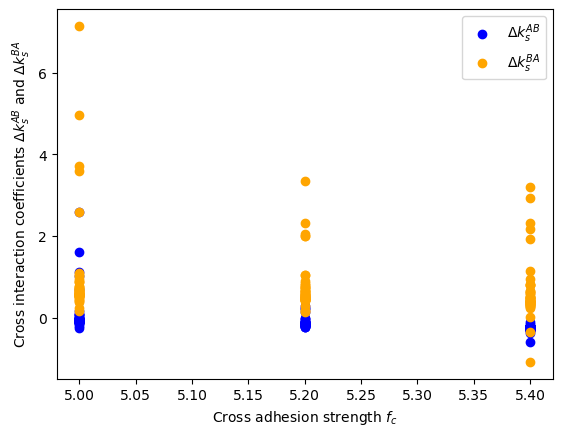

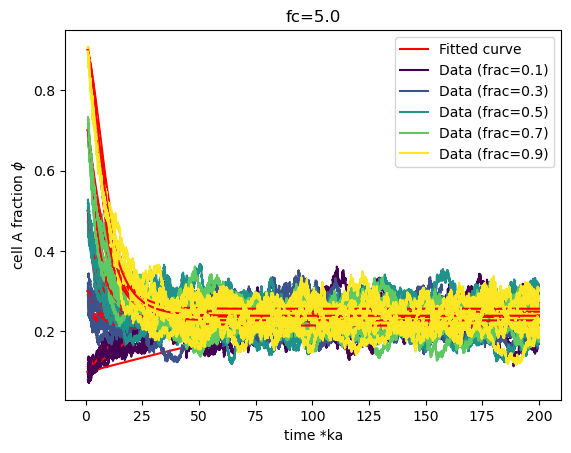

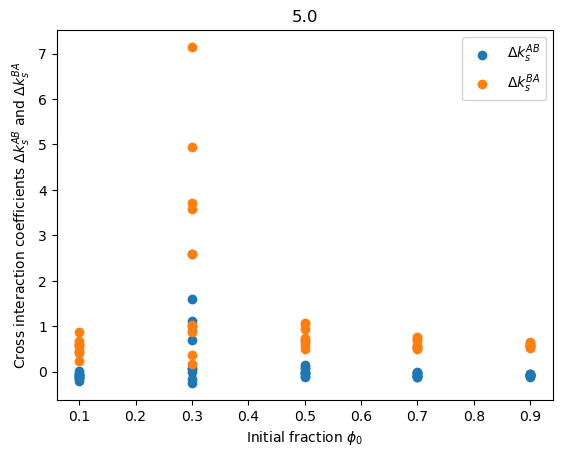

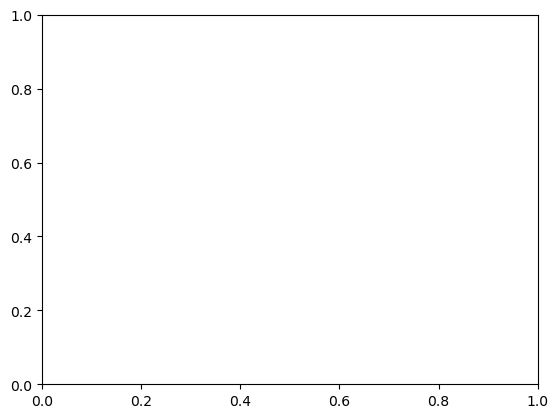

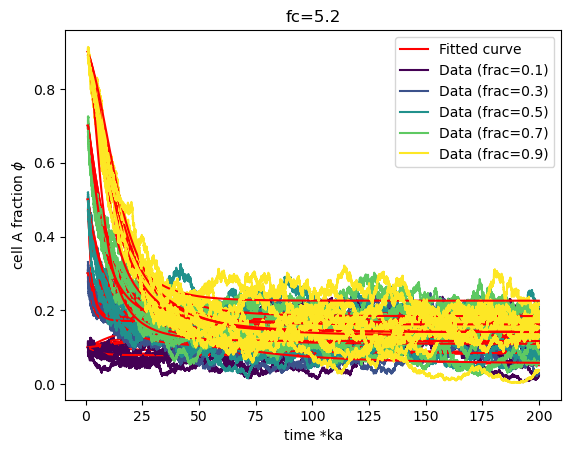

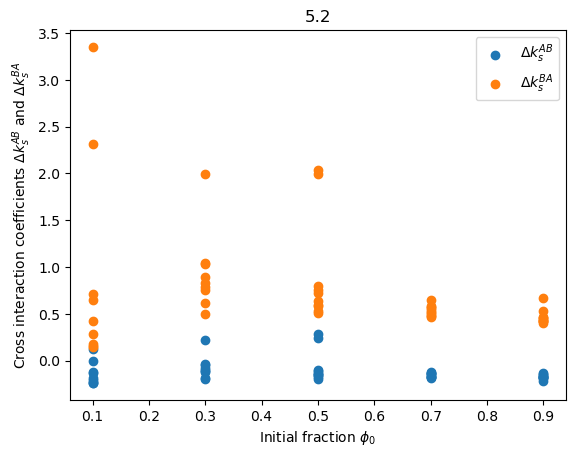

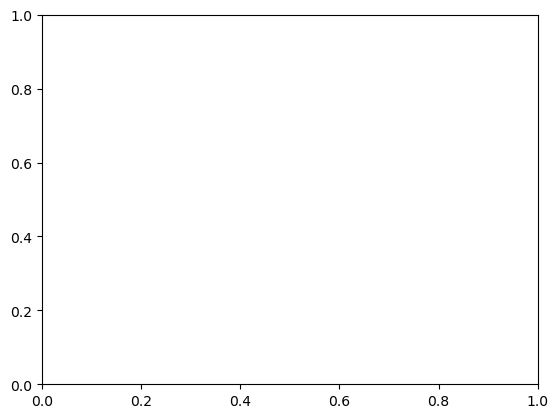

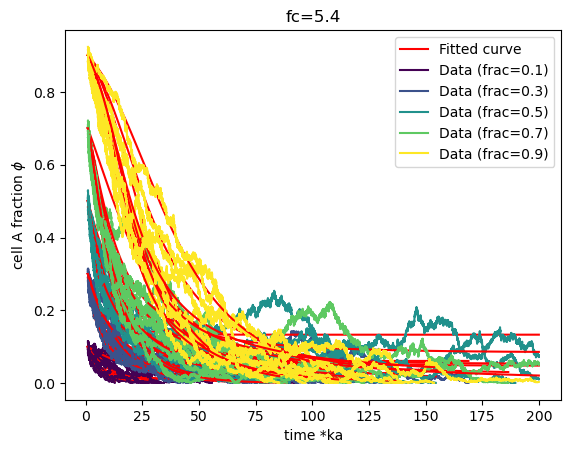

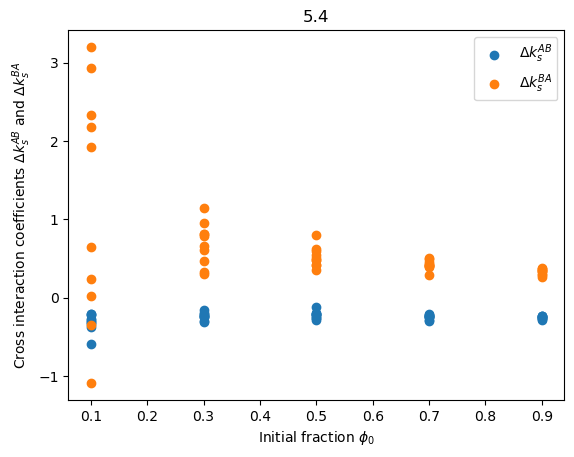

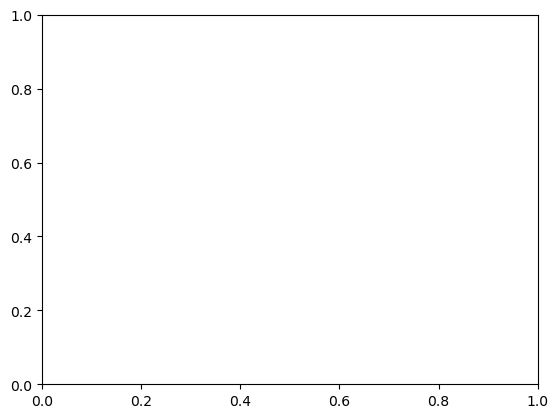

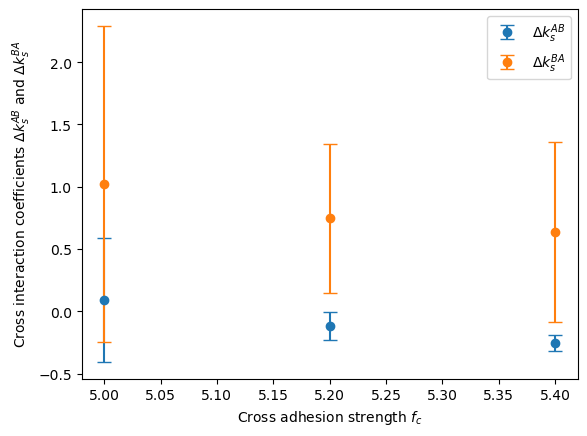

In [3]:
def ensure_directory_exists(directory_path):
    os.makedirs(directory_path, exist_ok=True)

folder_path = './'
folders = sorted([f for f in os.listdir(folder_path) if f.startswith('f12')])
fig3, ax3 = plt.subplots()  # Plot for dks vs fc

dksa_mean_list, dksb_mean_list, dksa_std_list, dksb_std_list, fc_list = [], [], [], [], []

positions = [0,2,4]


for i, folder in enumerate([folders[i] for i in positions]):
    fc = float(folder.split('_')[-1])
    subfolder_path = os.path.join(folder_path, folder)
    subfolders = sorted([f for f in os.listdir(subfolder_path) if f.startswith('frac')])
    color_map = {}
    color_list= cm.viridis(np.linspace(0, 1, len(subfolders)))  # Create a colormap
    color_index = 0
    frac_list = []
    dksa_list = []
    dksb_list = []
    fig1, ax1 = plt.subplots()  # Plot for phi vs time
    fig2, ax2 = plt.subplots()  # Plot for dks vs phi0
    fig4, ax4 = plt.subplots()  # Plot for pressure
    for subfolder in subfolders:
        subsubfolder_path = os.path.join(subfolder_path, subfolder)
        subsubfolders = sorted([f for f in os.listdir(subsubfolder_path) if f.startswith('rep')])
        for subsubfolder in subsubfolders:
            final_path = os.path.join(subsubfolder_path, subsubfolder)
            frac = float(subfolder.split('_')[-1])
            if frac not in color_map:
                color_map[frac] = color_list[color_index]
                color_index += 1
            try:
                frac, dksa, dksb = read_numcell_and_plot(final_path, ax1, color_map,frac)
                frac_list.append(frac)
                dksa_list.append(dksa)
                dksb_list.append(dksb)
                vars = [dksa, dksb]
                #read_pressure_and_plot(final_path, vars, ax4, window_size=20)
            except Exception as e:
                print(e)
                continue
    try:
        dksa_mean, dksa_std = np.mean(dksa_list), np.std(dksa_list)
        dksb_mean, dksb_std = np.mean(dksb_list), np.std(dksb_list)
        dksa_mean_list.append(dksa_mean)
        dksb_mean_list.append(dksb_mean)
        dksa_std_list.append(dksa_std)
        dksb_std_list.append(dksb_std)
        fc_list.append(fc)
    except Exception as e:
        print(e)
        continue
    plot_dks_phi(ax2, frac_list, dksa_list, dksb_list)
    ax2.set_title(fc)
    plot_dks_fc(ax3, fc, dksa_list, dksb_list)
    
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys())
# Delete the repeated label
handles, labels = ax3.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys())

# Plot a dksa, dksb as a function of fc with errorbar
plt.figure()
plt.errorbar(fc_list, dksa_mean_list, yerr=dksa_std_list, fmt='o', capsize=5, label=r'$\Delta k_s^{AB}$')
plt.errorbar(fc_list, dksb_mean_list, yerr=dksb_std_list, fmt='o', capsize=5, label=r'$\Delta k_s^{BA}$')
plt.xlabel(r'Cross adhesion strength $f_c$')
plt.ylabel(r'Cross interaction coefficients $\Delta k_s^{AB}$ and $\Delta k_s^{BA}$')
plt.legend()

plt.show()

index 0 is out of bounds for axis 0 with size 0
operands could not be broadcast together with shapes (2503,) (19599,) 
operands could not be broadcast together with shapes (2660,) (17130,) 
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


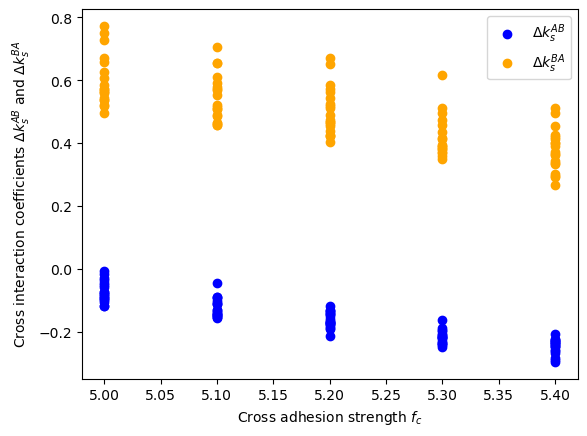

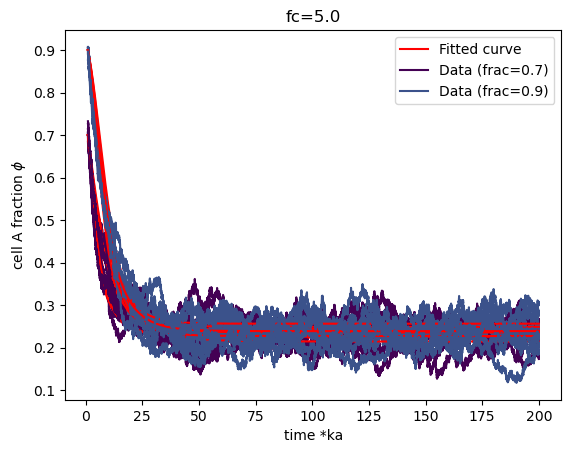

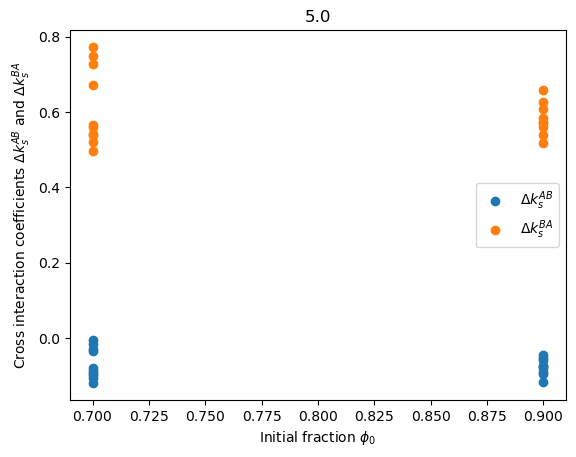

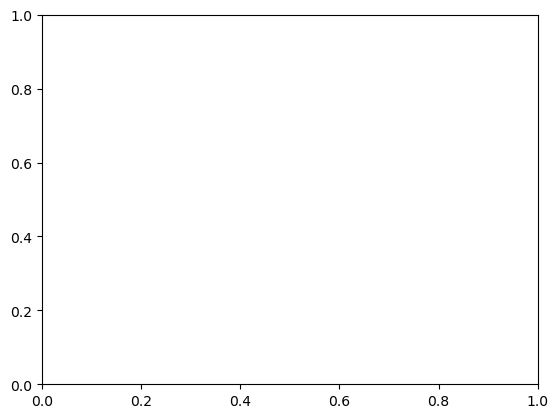

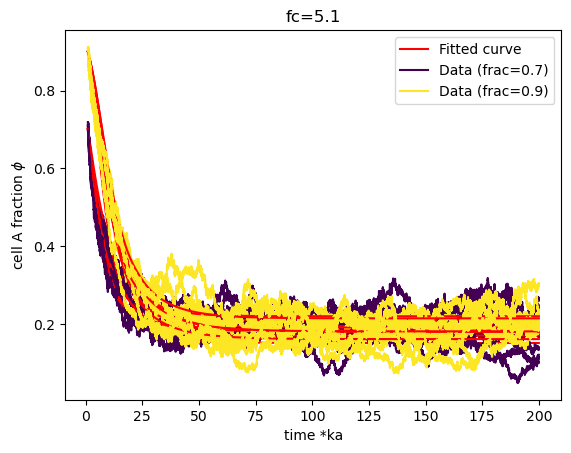

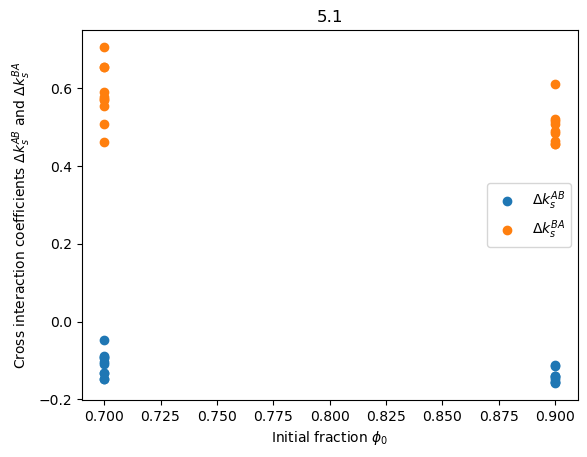

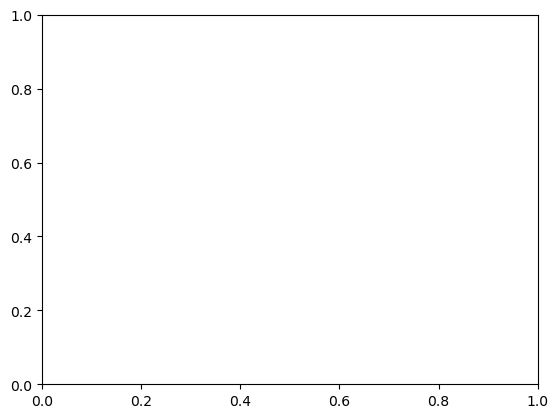

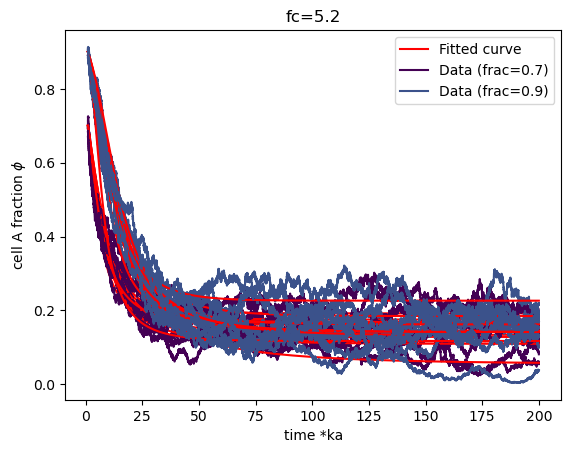

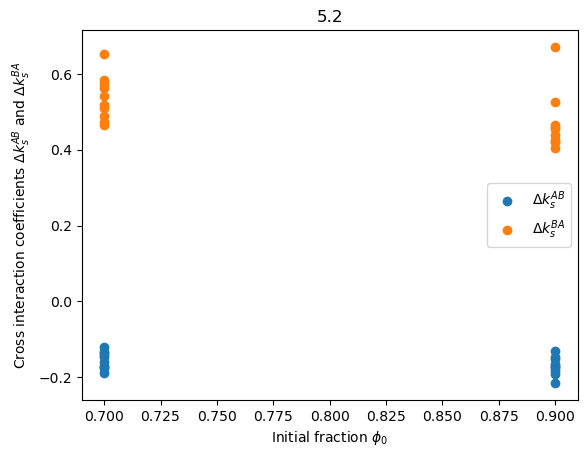

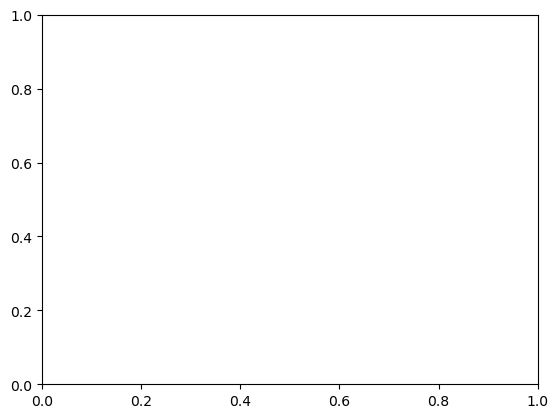

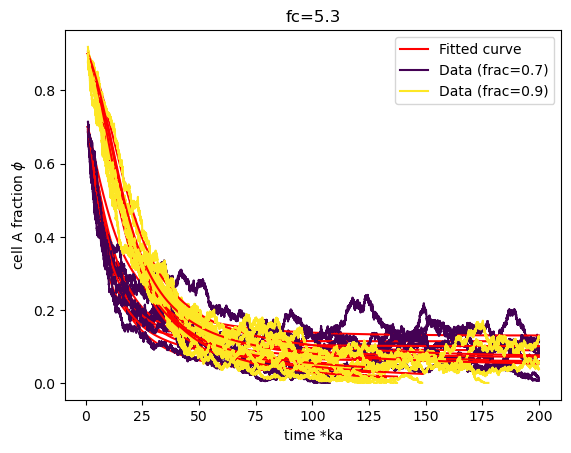

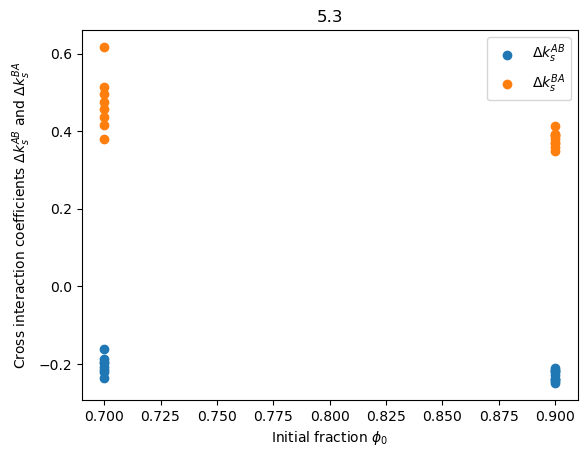

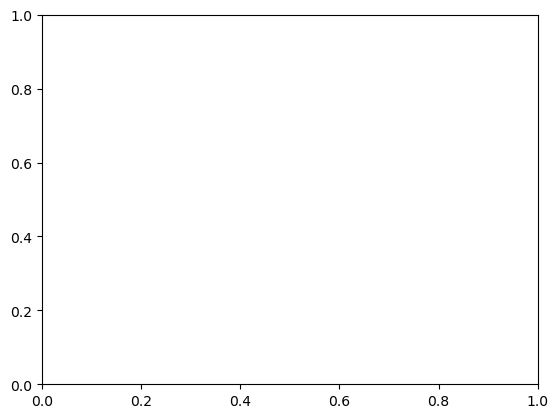

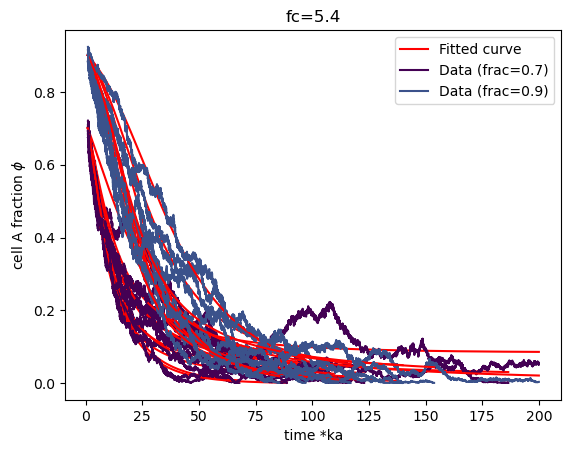

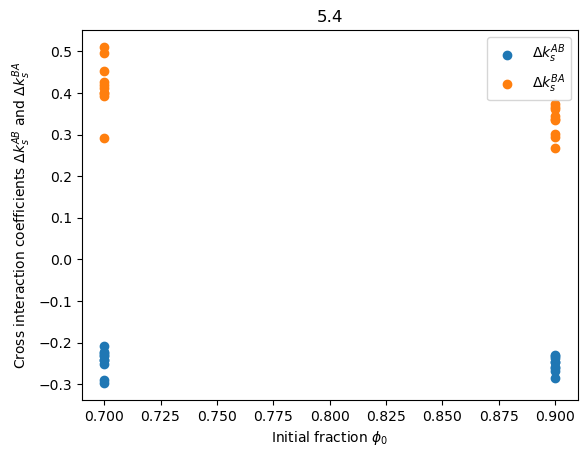

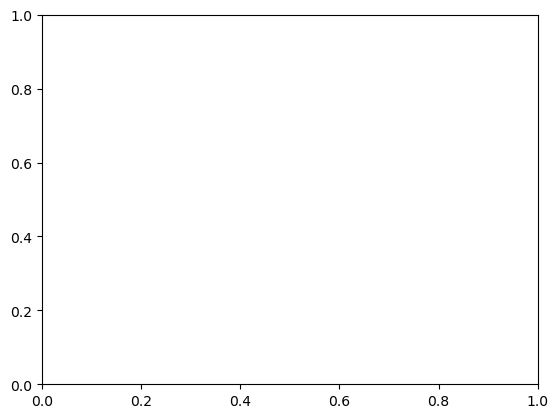

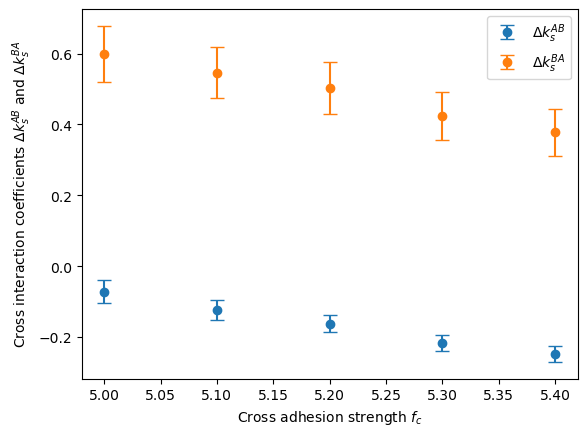

In [9]:
def ensure_directory_exists(directory_path):
    os.makedirs(directory_path, exist_ok=True)

folder_path = './'
folders = sorted([f for f in os.listdir(folder_path) if f.startswith('f12')])
fig3, ax3 = plt.subplots()  # Plot for dks vs fc

dksa_mean_list, dksb_mean_list, dksa_std_list, dksb_std_list, fc_list = [], [], [], [], []

positions = [0,1,2,3,4]


for i, folder in enumerate([folders[i] for i in positions]):
    fc = float(folder.split('_')[-1])
    subfolder_path = os.path.join(folder_path, folder)
    subfolders = sorted([f for f in os.listdir(subfolder_path) if f.startswith('frac')])
    color_map = {}
    color_list= cm.viridis(np.linspace(0, 1, len(subfolders)))  # Create a colormap
    color_index = 0
    frac_list = []
    dksa_list = []
    dksb_list = []
    fig1, ax1 = plt.subplots()  # Plot for phi vs time
    fig2, ax2 = plt.subplots()  # Plot for dks vs phi0
    fig4, ax4 = plt.subplots()  # Plot for pressure
    for subfolder in subfolders[-2:]:
        subsubfolder_path = os.path.join(subfolder_path, subfolder)
        subsubfolders = sorted([f for f in os.listdir(subsubfolder_path) if f.startswith('rep')])
        for subsubfolder in subsubfolders:
            final_path = os.path.join(subsubfolder_path, subsubfolder)
            frac = float(subfolder.split('_')[-1])
            if frac not in color_map:
                color_map[frac] = color_list[color_index]
                color_index += 1
            try:
                frac, dksa, dksb = read_numcell_and_plot(final_path, ax1, color_map,frac)
                frac_list.append(frac)
                dksa_list.append(dksa)
                dksb_list.append(dksb)
                vars = [dksa, dksb]
                #read_pressure_and_plot(final_path, vars, ax4, window_size=20)
            except Exception as e:
                print(e)
                continue
    try:
        dksa_mean, dksa_std = np.mean(dksa_list), np.std(dksa_list)
        dksb_mean, dksb_std = np.mean(dksb_list), np.std(dksb_list)
        dksa_mean_list.append(dksa_mean)
        dksb_mean_list.append(dksb_mean)
        dksa_std_list.append(dksa_std)
        dksb_std_list.append(dksb_std)
        fc_list.append(fc)
    except Exception as e:
        print(e)
        continue
    plot_dks_phi(ax2, frac_list, dksa_list, dksb_list)
    ax2.set_title(fc)
    plot_dks_fc(ax3, fc, dksa_list, dksb_list)
    
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys())
# Delete the repeated label
handles, labels = ax3.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys())

# Plot a dksa, dksb as a function of fc with errorbar
plt.figure()
plt.errorbar(fc_list, dksa_mean_list, yerr=dksa_std_list, fmt='o', capsize=5, label=r'$\Delta k_s^{AB}$')
plt.errorbar(fc_list, dksb_mean_list, yerr=dksb_std_list, fmt='o', capsize=5, label=r'$\Delta k_s^{BA}$')
plt.xlabel(r'Cross adhesion strength $f_c$')
plt.ylabel(r'Cross interaction coefficients $\Delta k_s^{AB}$ and $\Delta k_s^{BA}$')
plt.legend()

plt.show()

Instead of fitting each pair of coefficients by every single cell fraction A evolution, we globally fit pair of coefficients by all cell A fraction A evolution from different initial fraction. This method avoids the error bar and thus avoids the explanation of the error.

5.0
Skipping ./f12_5.0/frac_0.5/rep_6 due to insufficient data size: 1
Skipping ./f12_5.0/frac_0.9/rep_3 due to insufficient data size: 1
-0.07728713426745275 0.5878474601786846
5.1
Skipping ./f12_5.1/frac_0.1/rep_2 due to insufficient data size: 0
-0.12513571836958487 0.5395271029670622
5.2
Skipping ./f12_5.2/frac_0.1/rep_2 due to insufficient data size: 1
Skipping ./f12_5.2/frac_0.3/rep_5 due to insufficient data size: 2
-0.17504795855239835 0.4729075273553358
5.3
Skipping ./f12_5.3/frac_0.1/rep_10 due to insufficient data size: 1
Skipping ./f12_5.3/frac_0.7/rep_8 due to insufficient data size: 1
Skipping ./f12_5.3/frac_0.9/rep_10 due to insufficient data size: 1
-0.21313508297345973 0.4221047953016114
5.4
Skipping ./f12_5.4/frac_0.9/rep_1 due to insufficient data size: 0
-0.2437822831299669 0.3563668672517669


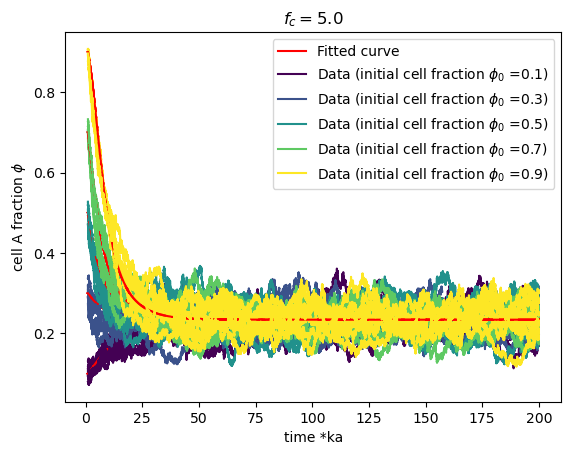

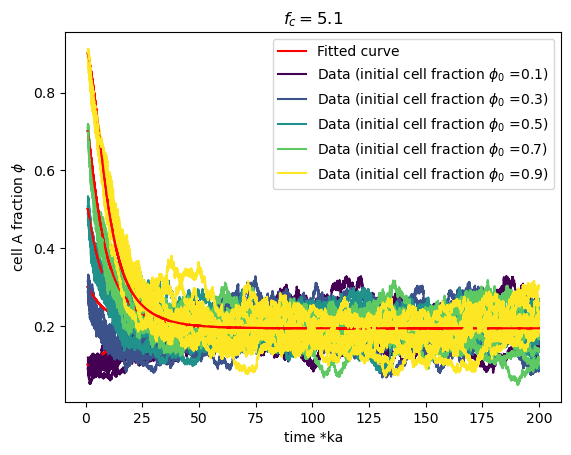

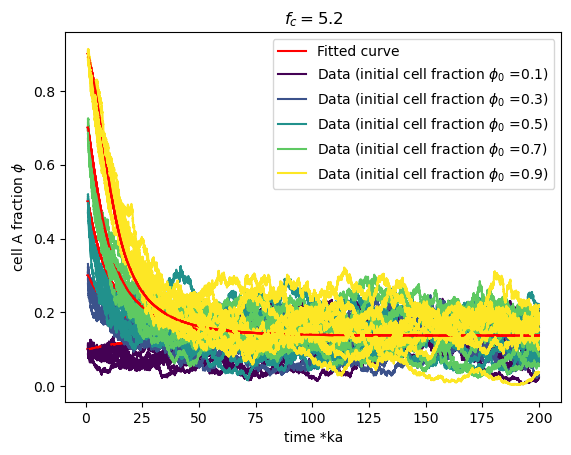

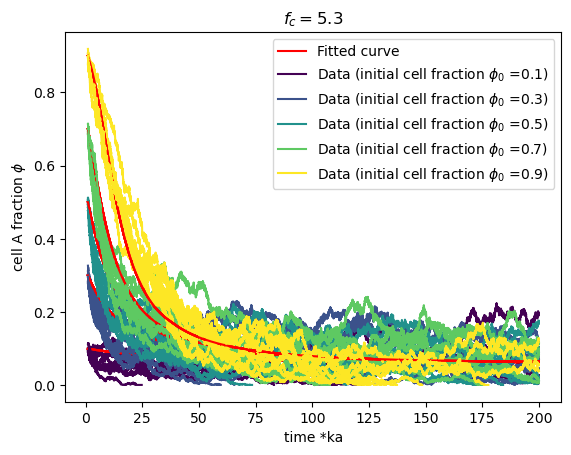

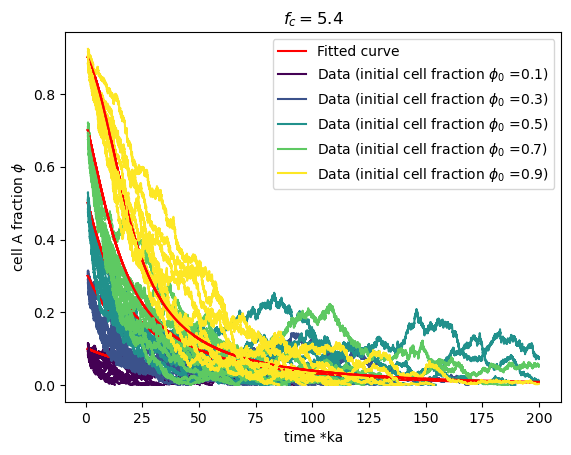

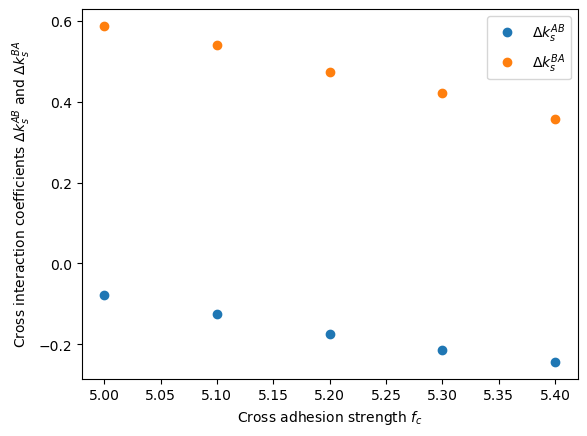

In [43]:
from scipy.optimize import minimize, OptimizeWarning
import warnings

# Define the global loss function to fit all data simultaneously
def global_loss_function(params, data_sets):
    total_loss = 0
    Delta_k_s_AB, Delta_k_s_BA = params

    for t_data, phi_data, frac in data_sets:
        phi_model = model_function(params, t_data, frac)
        total_loss += np.sum((phi_model - phi_data) ** 2)

    return total_loss

# Modified fitting function for global fitting
def global_fit_and_plot(subfolders, subfolder_path, ax1, color_map):
    fc_folder = subfolder_path.split('/')[-1].split('_')[-1]
    print(fc_folder)
    data_sets = []
    
    for subfolder in subfolders:
        subsubfolder_path = os.path.join(subfolder_path, subfolder)
        subsubfolders = sorted([f for f in os.listdir(subsubfolder_path) if f.startswith('rep')])

        for subsubfolder in subsubfolders:
            final_path = os.path.join(subsubfolder_path, subsubfolder)
            frac = float(subfolder.split('_')[-1])
            color = color_map[frac]

            try:
                data = pd.read_csv(final_path + "/numcells.dat", sep='\t')
                if len(data) <= 100:
                    print(f"Skipping {final_path} due to insufficient data size: {len(data)}")
                    continue
                
                t_data = (data.iloc[:, 0].values / 100)[100:]
                phi_data = (data.iloc[:, 1] / (data.iloc[:, 2] + data.iloc[:, 1])).values[100:]
                
                data_sets.append((t_data, phi_data, frac))
            except Exception as e:
                print(f"Skipping {final_path} due to error: {e}")
                continue

    if len(data_sets) == 0:
        print(f"No valid data found in {subfolder_path}")
        return None, None

    # Perform global fitting with improved handling
    initial_guess = [-0.1, 0.5]  # Improved initial guess
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", OptimizeWarning)  # Ignore precision loss warnings
        result = minimize(global_loss_function, initial_guess, args=(data_sets,), method='L-BFGS-B', options={'maxiter': 1000, 'ftol': 1e-9})
    if not result.success:
        print(f"Optimization failed for {subfolder_path} with message: {result.message}")
        return None, None

    Delta_k_s_AB, Delta_k_s_BA = result.x
    print(Delta_k_s_AB,Delta_k_s_BA)

    # Plot all data and the global fitted curve
    for t_data, phi_data, frac in data_sets:
        ax1.plot(t_data, model_function(result.x, t_data, frac), 'r-', label='Fitted curve')
        ax1.plot(t_data, phi_data, color=color_map[frac], label=f'Data (initial cell fraction $\phi_0$ ={frac})')


    ax1.set_xlabel('time *ka')
    ax1.set_ylabel(r'cell A fraction $\phi$')
    ax1.set_title('$f_c=$'+fc_folder)
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys())

    return Delta_k_s_AB, Delta_k_s_BA

# Main loop to process folders and globally fit data
dksa_mean_list, dksb_mean_list, fc_list = [], [], []

folder_path = './'
folders = sorted([f for f in os.listdir(folder_path) if f.startswith('f12')])
positions = [0,1,2,3,4]  # The indices you selected for folders

for i, folder in enumerate([folders[i] for i in positions]):
    fc = float(folder.split('_')[-1])
    subfolder_path = os.path.join(folder_path, folder)
    subfolders = sorted([f for f in os.listdir(subfolder_path) if f.startswith('frac')])
    
    color_map = {}
    color_list = cm.viridis(np.linspace(0, 1, len(subfolders)))  # Create a colormap
    color_index = 0
    
    for subfolder in subfolders:
        frac = float(subfolder.split('_')[-1])
        if frac not in color_map:
            color_map[frac] = color_list[color_index]
            color_index += 1

    fig1, ax1 = plt.subplots()  # Plot for phi vs time

    try:
        dksa, dksb = global_fit_and_plot(subfolders, subfolder_path, ax1, color_map)
        if dksa is not None and dksb is not None:
            dksa_mean_list.append(dksa)
            dksb_mean_list.append(dksb)
            fc_list.append(fc)
    except Exception as e:
        print(f"Skipping folder {folder} due to error: {e}")
        continue

# Plot a dksa, dksb as a function of fc with errorbar
plt.figure()
plt.plot(fc_list, dksa_mean_list, 'o', label=r'$\Delta k_s^{AB}$')
plt.plot(fc_list, dksb_mean_list, 'o', label=r'$\Delta k_s^{BA}$')
plt.xlabel(r'Cross adhesion strength $f_c$')
plt.ylabel(r'Cross interaction coefficients $\Delta k_s^{AB}$ and $\Delta k_s^{BA}$')
plt.legend()
plt.show()


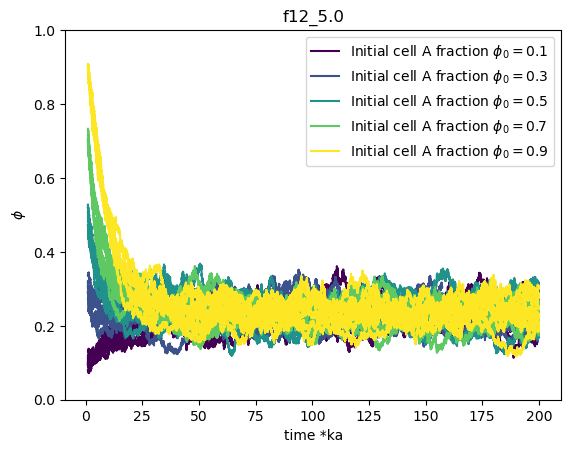

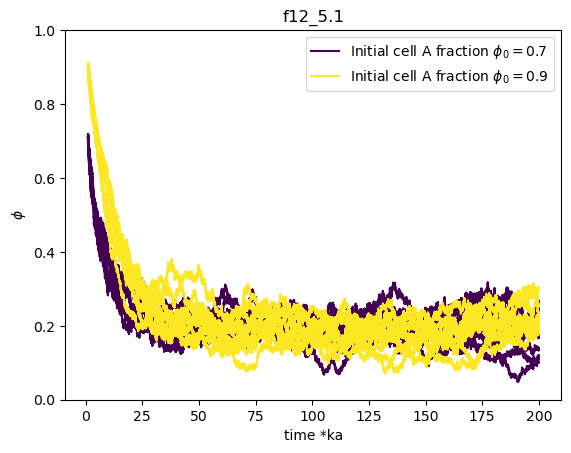

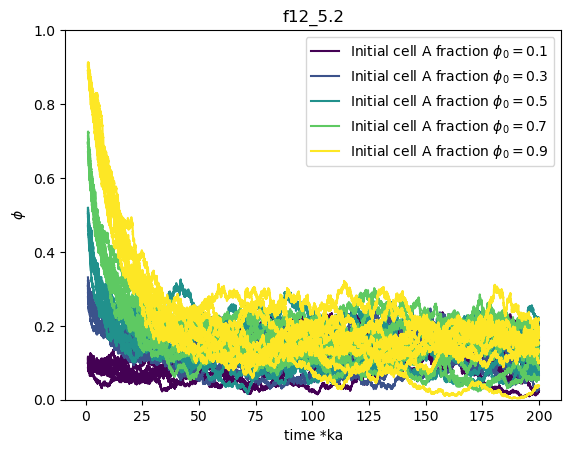

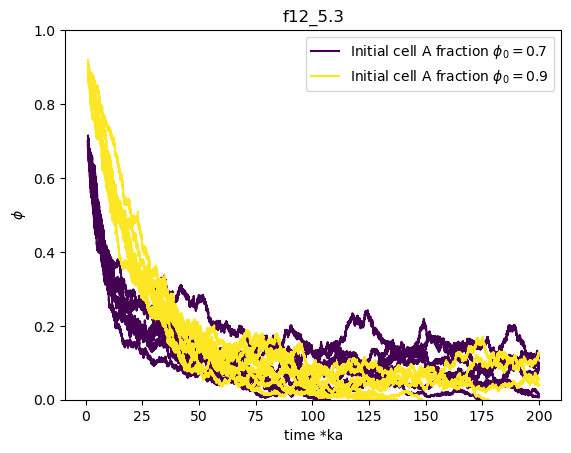

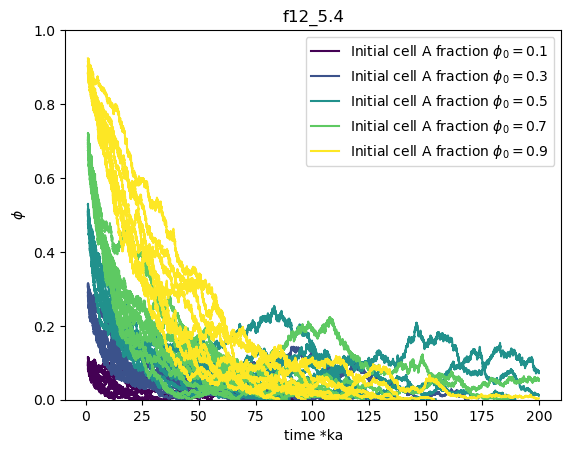

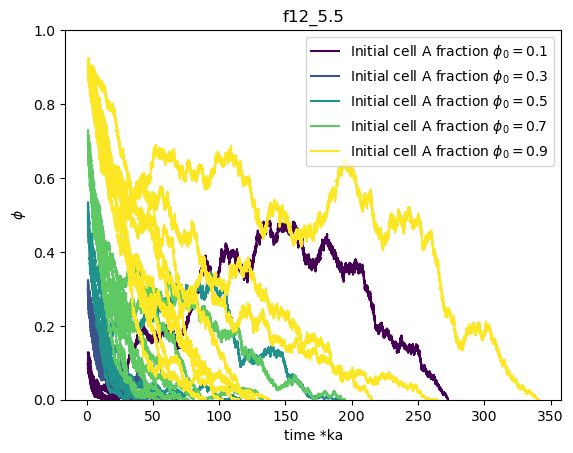

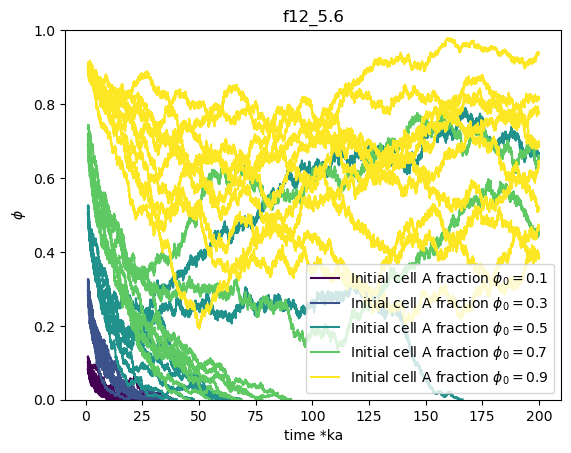

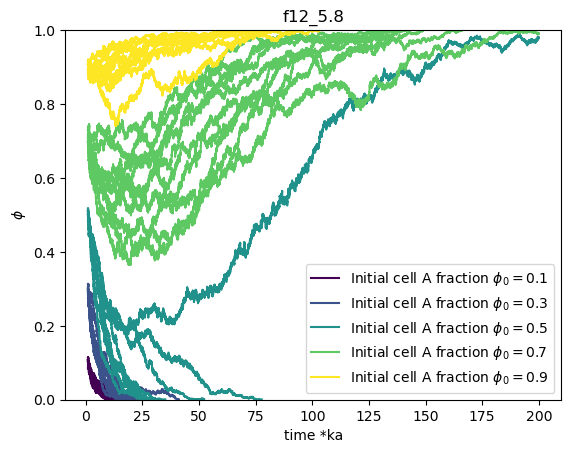

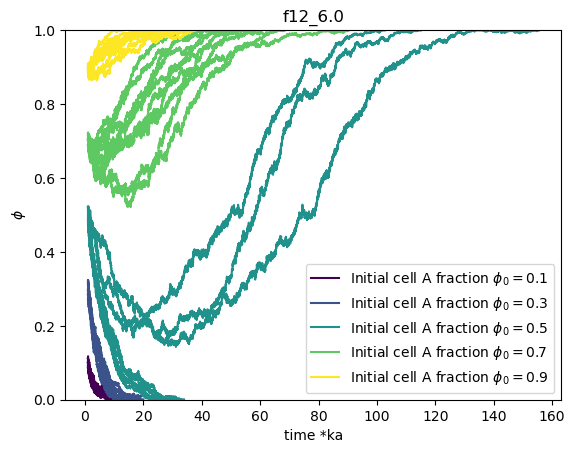

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_numcell_and_plot3(file_path, ax, color_map, frac):
    fc = file_path.split('/')[-4]
    data = pd.read_csv(file_path, sep='\t')  # read file
    t_data = (data.iloc[:, 0].values / 100)[100:]  # normalized time by multiplying apoptosis rate
    phi_data = (data.iloc[:, 1] / (data.iloc[:, 2] + data.iloc[:, 1])).values[100:]  # evolution of fraction of cell A
    initial_guess = [1, 0]
    # result = minimize(loss_function, initial_guess, args=(t_data[:-300], phi_data[:-300], frac))  # obtain cross interaction coefficients by fitting function
    # dksa, dksb = result.x[0], result.x[1]  # cross interaction coefficients
    dksa, dksb = 0, 0
    color = color_map[frac]  # get the color for the current frac
    ax.plot(t_data, phi_data, color=color, label=r'Initial cell A fraction $\phi_0=$' + str(frac))
    # ax.plot(t_data, model_function(result.x, t_data, frac), 'r-', label='Fitted curve' + r'$\Delta k_s^{AB}=$ ' + str(np.round(dksa, 3)) + r' $\Delta k_s^{BA}=$ ' + str(np.round(dksb, 3)))
    ax.set_xlabel('time *ka')
    ax.set_ylabel(r'$\phi$')
    ax.set_title(fc)
    # ax.legend()
    ax.set_ylim(0, 1)
    return frac, dksa, dksb

folder_path = './'
folders = sorted([f for f in os.listdir(folder_path) if f.startswith('f12')])

# Define a color map for frac values


for folder in folders:
    fc = folder.split('_')[-1]
    subfolder_path = os.path.join(folder_path, folder)
    subfolders = sorted([f for f in os.listdir(subfolder_path) if f.startswith('frac')])
    color_map = {}
    color_list = plt.cm.viridis(np.linspace(0, 1, len(subfolders)))  # Generate a list of colors
    color_index = 0
    frac_list = []
    dksa_list = []
    dksb_list = []
    fig1, ax1 = plt.subplots()  # plot for phi vs time

    for subfolder in subfolders:
        subsubfolder_path = os.path.join(subfolder_path, subfolder)
        subsubfolders = sorted([f for f in os.listdir(subsubfolder_path) if f.startswith('rep')])

        for subsubfolder in subsubfolders:
            numcells_path = os.path.join(subsubfolder_path, subsubfolder) + '/numcells.dat'
            frac = float(subfolder.split('_')[-1])
            if frac not in color_map:
                color_map[frac] = color_list[color_index]
                color_index += 1

            try:
                frac, dksa, dksb = read_numcell_and_plot3(numcells_path, ax1, color_map, frac)
                frac_list.append(frac)
                dksa_list.append(dksa)
                dksb_list.append(dksb)
            except:
                continue

    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys())


..
..
..
..
..


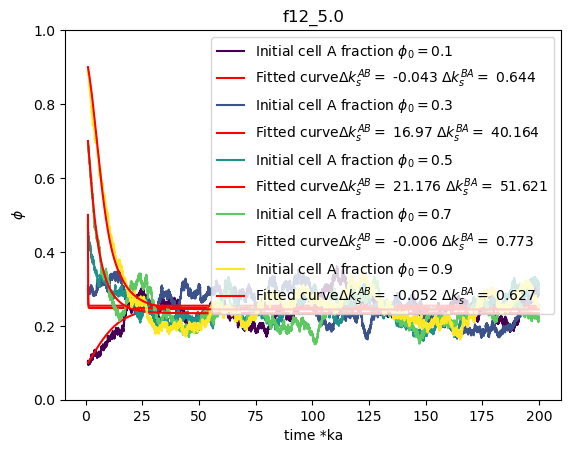

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_numcell_and_plot3(file_path, ax, color_map, frac):
    fc = file_path.split('/')[-4]
    data = pd.read_csv(file_path, sep='\t')  # read file
    t_data = (data.iloc[:, 0].values / 100)[100:]  # normalized time by multiplying apoptosis rate
    phi_data = (data.iloc[:, 1] / (data.iloc[:, 2] + data.iloc[:, 1])).values[100:]  # evolution of fraction of cell A
    initial_guess = [1, 0]
    result = minimize(loss_function, initial_guess, args=(t_data[:-300], phi_data[:-300], frac))  # obtain cross interaction coefficients by fitting function
    dksa, dksb = result.x[0], result.x[1]  # cross interaction coefficients
    #dksa, dksb = 0, 0
    color = color_map[frac]  # get the color for the current frac
    ax.plot(t_data, phi_data, color=color, label=r'Initial cell A fraction $\phi_0=$' + str(frac))
    ax.plot(t_data, model_function(result.x, t_data, frac), 'r-', label='Fitted curve' + r'$\Delta k_s^{AB}=$ ' + str(np.round(dksa, 3)) + r' $\Delta k_s^{BA}=$ ' + str(np.round(dksb, 3)))
    ax.set_xlabel('time *ka')
    ax.set_ylabel(r'$\phi$')
    ax.set_title(fc)
    # ax.legend()
    ax.set_ylim(0, 1)
    return frac, dksa, dksb

folder_path = './'
folders = sorted([f for f in os.listdir(folder_path) if f.startswith('f12')])

# Define a color map for frac values

positions=[0]
for folder in [folders[i] for i in positions]:
    fc = folder.split('_')[-1]
    subfolder_path = os.path.join(folder_path, folder)
    subfolders = sorted([f for f in os.listdir(subfolder_path) if f.startswith('frac')])
    color_map = {}
    color_list = plt.cm.viridis(np.linspace(0, 1, len(subfolders)))  # Generate a list of colors
    color_index = 0
    frac_list = []
    dksa_list = []
    dksb_list = []
    fig1, ax1 = plt.subplots()  # plot for phi vs time

    for subfolder in subfolders:
        subsubfolder_path = os.path.join(subfolder_path, subfolder)
        subsubfolders = sorted([f for f in os.listdir(subsubfolder_path) if f.startswith('rep')])

        for subsubfolder in subsubfolders[:1]:
            print('..')
            numcells_path = os.path.join(subsubfolder_path, subsubfolder) + '/numcells.dat'
            frac = float(subfolder.split('_')[-1])
            if frac not in color_map:
                color_map[frac] = color_list[color_index]
                color_index += 1

            try:
                frac, dksa, dksb = read_numcell_and_plot3(numcells_path, ax1, color_map, frac)
                frac_list.append(frac)
                dksa_list.append(dksa)
                dksb_list.append(dksb)
            except:
                continue

    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys())


Steps:
1. Acquire the final coexitence cell A fraction $\phi^*$ by averaging the fraction from file 'numcells.dat' when the system reaches to equilibrium.
2. Acquire the final stable system pressure $P^*$ by averaging the pressure averaging the fraction from file '__curp.dat' when the system reaches to equilibrium.
3. Acquire the cross interaction coefficients by solving the equations of the formulas above.
4. Plot cross interactio coefficients as a function of cross adhesion strength

/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slic

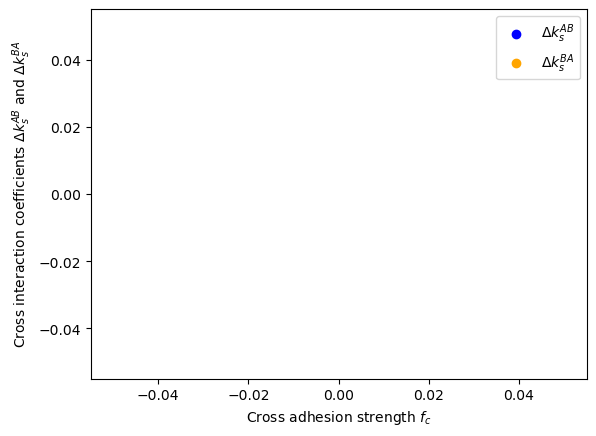

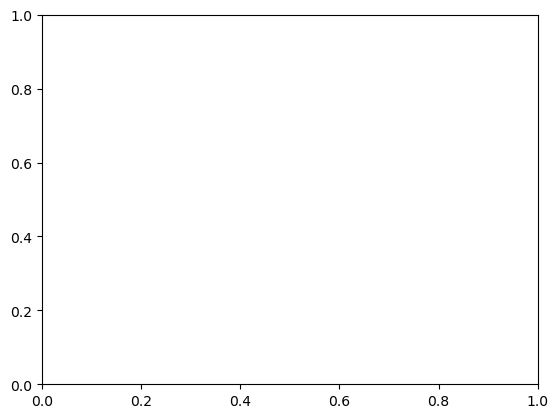

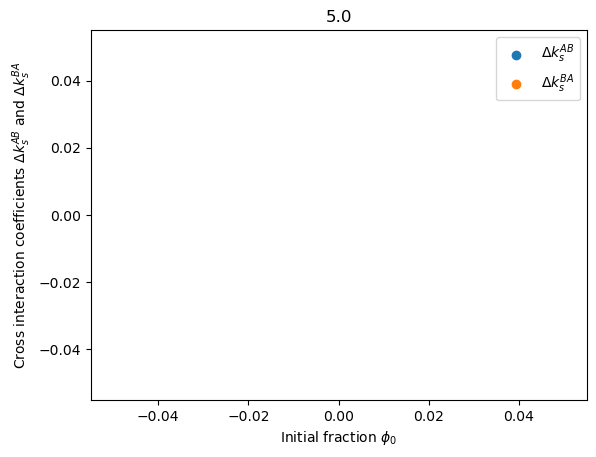

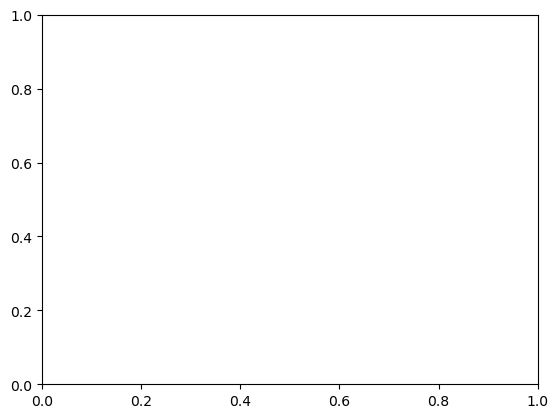

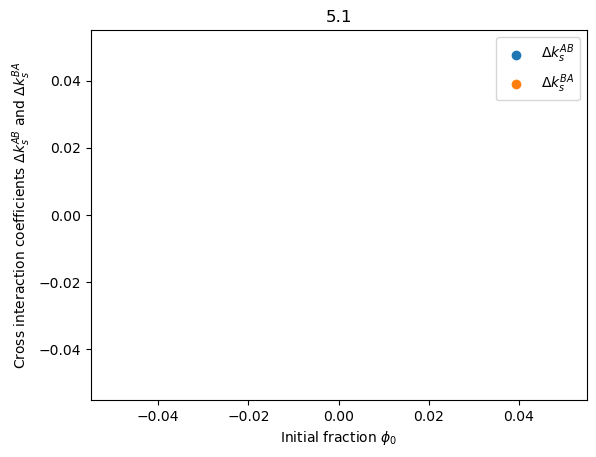

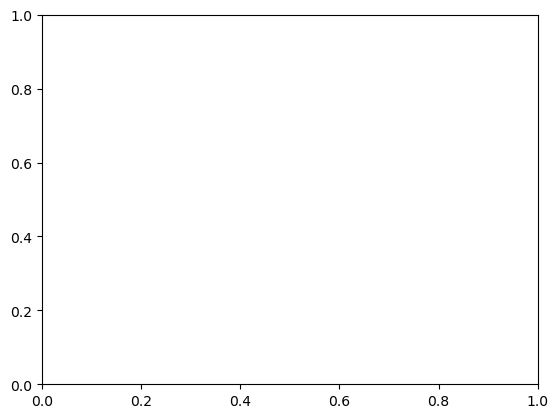

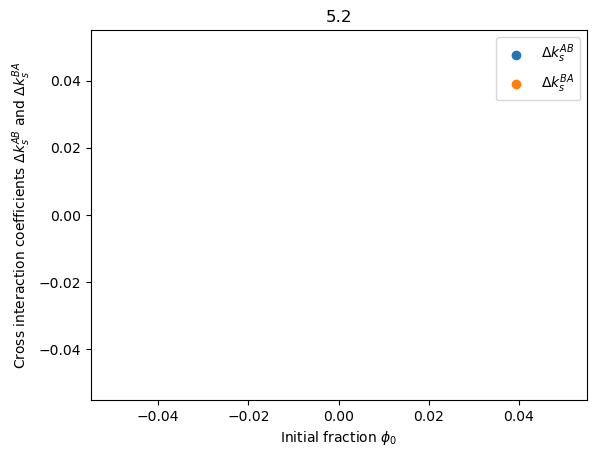

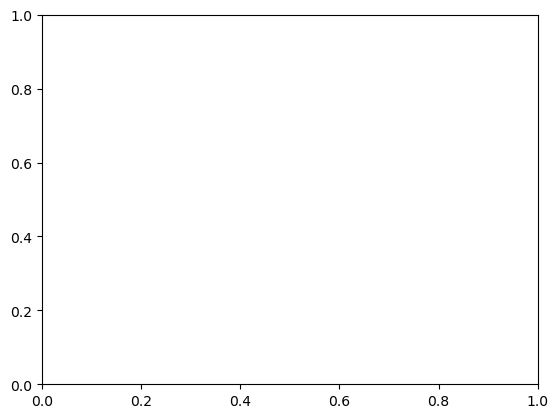

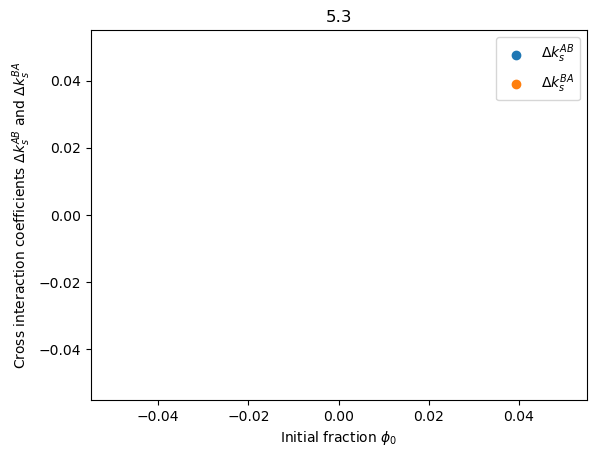

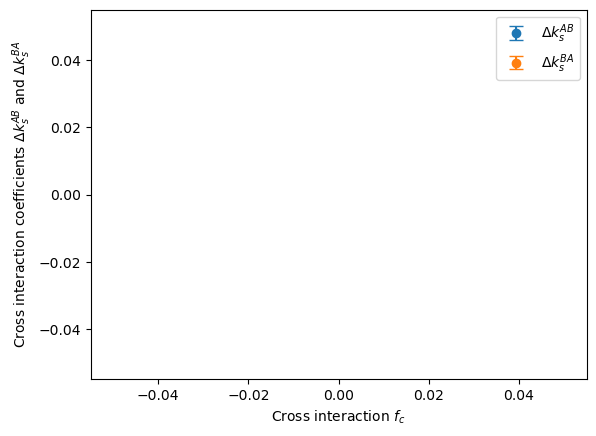

In [8]:
folder_path = './'
folders = sorted([f for f in os.listdir(folder_path) if f.startswith('f12')])
fig3,ax3=plt.subplots()#plot for dks vs fc

Delta_k_s_AB_mean_list,Delta_k_s_BA_mean_list,Delta_k_s_AB_std_list,Delta_k_s_BA_std_list,fc_list   = [],[],[],[],[]

positions=[0,1,2,3]
for folder in [folders[i] for i in positions]:
    fc = float(folder.split('_')[-1])
    subfolder_path = os.path.join(folder_path,folder)
    subfolders= sorted([f for f in os.listdir(subfolder_path) if f.startswith('frac')])

    frac_list=[]
    Delta_k_s_AB_list=[]
    Delta_k_s_BA_list=[]
    fig1,ax1=plt.subplots()#plot for phi vs time
    fig2,ax2=plt.subplots()#plot for dks vs phi0

    for subfolder in subfolders:
        subsubfolder_path = os.path.join(subfolder_path,subfolder)
        subsubfolders = sorted([f for f in os.listdir(subsubfolder_path) if f.startswith('rep')])
        for subsubfolder in subsubfolders:
            final_path = os.path.join(subsubfolder_path,subsubfolder)
            try:
                numcell_path = final_path+'/numcells.dat'
                data = pd.read_csv(numcell_path,sep='\t') #read file
                t_data = (data.iloc[:,0].values/100)[100:] # normalized time by multiplying apoptosis rate
                if t_data[-1]<195:
                    continue
                frac,Delta_k_s_AB,Delta_k_s_BA = read_numcell_and_plot2(final_path,ax1)
                frac_list.append(frac)
                Delta_k_s_AB_list.append(Delta_k_s_AB)
                Delta_k_s_BA_list.append(Delta_k_s_BA)
            except:
                continue
    try:
        Delta_k_s_AB_mean,Delta_k_s_AB_std = np.mean(Delta_k_s_AB_list),np.std(Delta_k_s_AB_list)
        Delta_k_s_BA_mean,Delta_k_s_BA_std = np.mean(Delta_k_s_BA_list),np.std(Delta_k_s_BA_list)
        Delta_k_s_AB_mean_list.append(Delta_k_s_AB_mean)    
        Delta_k_s_BA_mean_list.append(Delta_k_s_BA_mean)  
        Delta_k_s_AB_std_list.append(Delta_k_s_AB_std)  
        Delta_k_s_BA_std_list.append(Delta_k_s_BA_std)
        fc_list.append(fc) 
    except:
        continue
    plot_dks_phi(ax2,frac_list,Delta_k_s_AB_list,Delta_k_s_BA_list)
    ax2.set_title(fc)
    plot_dks_fc(ax3,fc,Delta_k_s_AB_list,Delta_k_s_BA_list)
# delete the repeated label   
handles, labels = ax3.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys())

#plot a Delta_k_s_AB,Delta_k_s_BA as a function of fc with errorbar
plt.figure()
plt.errorbar(fc_list, Delta_k_s_AB_mean_list, yerr=Delta_k_s_AB_std_list, fmt='o', capsize=5, label=r'$\Delta k_s^{AB}$')
plt.errorbar(fc_list, Delta_k_s_BA_mean_list, yerr=Delta_k_s_BA_std_list, fmt='o', capsize=5, label=r'$\Delta k_s^{BA}$')
plt.xlabel(r'Cross interaction $f_c$')
plt.ylabel(r'Cross interaction coefficients $\Delta k_s^{AB}$ and $\Delta k_s^{BA}$')
plt.legend()